In [ ]:
import os, sys, time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload() # upload your Kaggle.json API token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nidhinthomas0624","key":"d6e5eff4aa05d298587978307fc26023"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

100% 9.57G/9.58G [05:42<00:00, 32.2MB/s]
100% 9.58G/9.58G [05:42<00:00, 30.0MB/s]


In [ ]:
!unzip -q /content/chest-xray-masks-and-labels.zip

# PreProcess

In [ ]:
img_dir = './Lung Segmentation/CXR_png'
mask_dir = './Lung Segmentation/masks'
mask_names = os.listdir (mask_dir)

print (len (os.listdir (img_dir)))
print (len (os.listdir (mask_dir)))

800
704


In [ ]:
mask_names = os.listdir (mask_dir)

In [ ]:
print (os.listdir (img_dir) [-4])
print (os.listdir (mask_dir) [-4])

CHNCXR_0571_1.png
CHNCXR_0114_0_mask.png


In [ ]:
print (os.listdir (img_dir) [-3])
print (os.listdir (mask_dir) [-3])

CHNCXR_0396_1.png
CHNCXR_0043_0_mask.png


In [ ]:
def shuffle_split (mask_names, val_pct = 0.15, seed = 99):
    """ shuffling dataset with random state and split to tran and valid"""
    n_val = int (len (mask_names) * val_pct)
    np.random.seed (seed)
    idx = np.random.permutation (len (mask_names))
    mask_names = np.array (mask_names) [idx]

    return mask_names [n_val:], mask_names [:n_val]

In [ ]:
class lungDataset (Dataset):
    """ create a dataset and transform it to tensor and resize it to 512*512"""
    def __init__ (self, image_dir, mask_dir, mask_names, transform = None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.mask_names = mask_names
        self.transform = transform

    def __getitem__ (self, index):
        mask_path = os.path.join (self.mask_dir, self.mask_names [index])
        image_path = os.path.join (self.image_dir, self.mask_names [index].replace ('_mask.png', '.png') if 'mask' in self.mask_names [index] else self.mask_names [index])

        image = np.array (Image.open (image_path).convert ('L'), dtype = np.float32) #3 * 8byte True pixels
        mask = np.array (Image.open (mask_path).convert ('L'), dtype = np.float32) # 8 byte black & white pixels

        mask [mask == 255] = 1

        if self.transform is not None:
            augmentations = self.transform (image = image, mask =  mask)
            image = augmentations ['image']
            mask = augmentations ['mask']

        return image, mask

    def __len__ (self):
        return len (self.mask_names)

In [ ]:
trn_tfms = A.Compose (
[
    A.Resize (height = 512, width = 512),
#     A.Rotate (limit = 35, p = 1.0),
#     A.HorizontalFlip (p = 0.5),
#     A.VerticalFlip (p = 0.1),
    A.Normalize (0, 1, max_pixel_value = 255.0),
    ToTensorV2 ()
])

val_tfms = A.Compose (
[
    A.Resize (height = 512, width = 512),
    A.Normalize (0, 1, max_pixel_value = 255.0),
    ToTensorV2 ()
])

In [ ]:
# create dataset and dataloader
trn_mask_names, val_mask_names = shuffle_split (mask_names, seed = 1)

train_ds = lungDataset (img_dir, mask_dir, trn_mask_names, trn_tfms)
valid_ds = lungDataset (img_dir, mask_dir, val_mask_names, val_tfms)

train_dl = DataLoader (train_ds, batch_size = 4, shuffle = True, num_workers = 2, pin_memory = True)
valid_dl = DataLoader (train_ds, batch_size = 4, shuffle = False, num_workers = 2, pin_memory = True)

# Visualize

In [ ]:
def imshow (img, title = None):
    """ a function to show tensor images"""
    img = img.numpy ().transpose (1, 2, 0)
    mean = 0
    std = 1
    img = img * std + mean
    img = np.clip (img, 0, 1)

    plt.figure (figsize = (10, 8))
    plt.axis ('off')
    plt.imshow (img)
    if title:
        plt.title (title)

In [ ]:
print('image shape: ',train_ds [0][0].shape)
print('mask shape: ',train_ds [0][1].shape)

image shape:  torch.Size([1, 512, 512])
mask shape:  torch.Size([512, 512])


In [ ]:
img, msk = next (iter (train_dl))
img = torchvision.utils.make_grid (img, nrow = 2)
msk = msk.unsqueeze (1)
msk = torchvision.utils.make_grid (msk, nrow = 2)

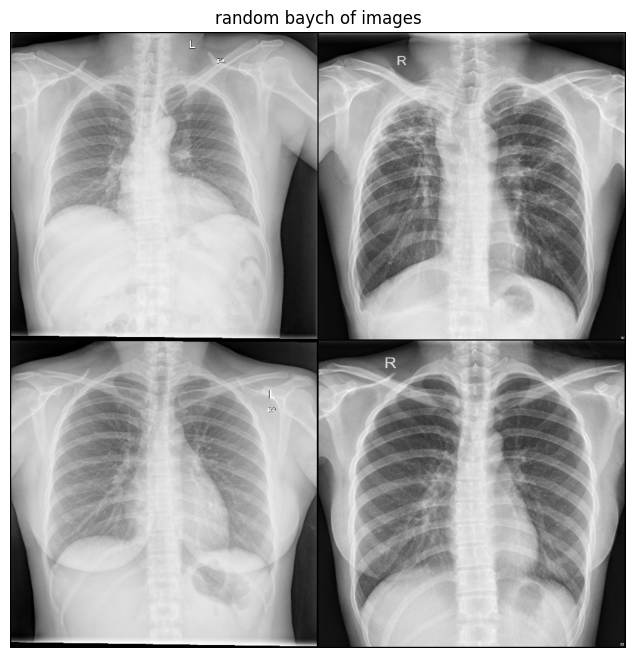

In [ ]:
imshow (img, 'random baych of images')

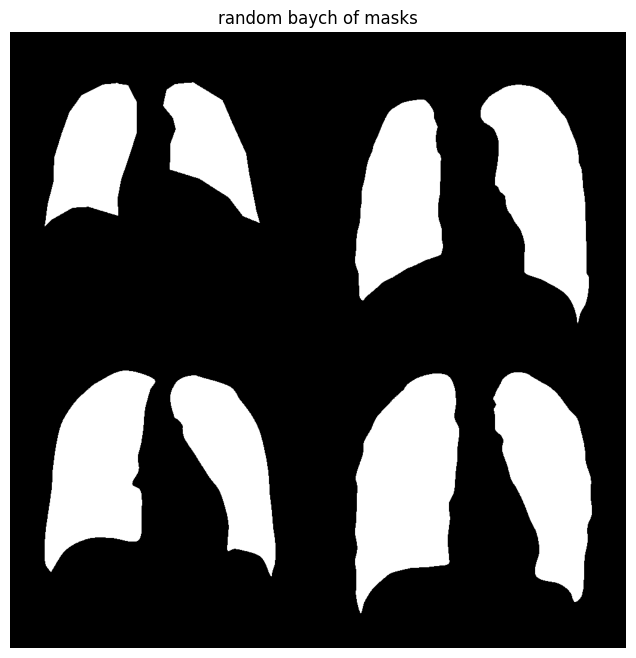

In [ ]:
imshow (msk, 'random baych of masks')

# Model

In [ ]:
class InitBlock (nn.Module):
    def __init__ (self, in_channels = 3, out_channels = 64, stride = 1):
        super(InitBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
            nn.ReLU (),
            nn.Conv2d (out_channels, out_channels, kernel_size = 3, padding = 1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)

In [ ]:
class ResBlock (nn.Module):
    def __init__ (self, in_channels, out_channels, stride = 2):
        super(ResBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d (in_channels),
            nn.ReLU (),
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
            nn.ReLU (),
            nn.Conv2d (out_channels, out_channels, kernel_size = 3, padding = 1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)

In [ ]:
class ResUnet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [64, 128, 256]):
        super(ResUnet, self).__init__()

        # input layer of resunet
        self.input = InitBlock (in_channels, features [0])

        self.downs = nn.ModuleList ()
        self.ups   = nn.ModuleList ()

        # down part of resunet & bridge part
        for feature in features:
            self.downs.append (ResBlock (feature, feature * 2, stride = 2))
            feature *= 2

        # up part of resunet
        for feature in reversed (features):
            self.ups.append (nn.ConvTranspose2d (2 * feature, 2 * feature, kernel_size = 2, stride = 2))
            self.ups.append (ResBlock (2 * feature + feature, feature, stride = 1))

        self.output = nn.Conv2d(features [0], out_channels, kernel_size = 1)

    def forward (self, x):
        skip_connections = []
        x = self.input (x)
        skip_connections.append (x)

        for i, down in enumerate (self.downs):
            x = down (x)
            if i < 2:
                skip_connections.append (x)

        skip_connections = skip_connections [::-1]

        for idx in range (0, len (self.ups), 2):
            x = self.ups [idx] (x)
            skip_connection = skip_connections [idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize (x, skip_connection.shape [2:])

            concat_skip = torch.cat ((skip_connection, x), dim = 1)
            x = self.ups [idx + 1] (concat_skip)

        return self.output (x)

# Training

In [ ]:
class lungLoss (nn.Module):
    """ BCE , jaccard_loss and dice_loss """
    def __init__ (self, weight = None, size_average = True):
        super (lungLoss, self).__init__ ()

    def forward (self, outputs, targets, smooth = 1e-8):
        # comment out if your model contains a sigmoid or equivalent activation loss
        outputs = torch.sigmoid (outputs)

        # flatten label and prediction tensors
        outputs = outputs.view (-1)
        targets = targets.view (-1)

        intersection = (outputs * targets).sum ()
        union = (outputs.sum () + targets.sum ()) - intersection

        jaccard_loss = 1 - (intersection / (union + smooth))
        dice_loss = 1 - (2. * intersection) / (outputs.sum () + targets.sum () + smooth)
        BCE = F.binary_cross_entropy (outputs, targets, reduction = 'mean')

        loss = BCE + jaccard_loss + dice_loss

        return loss

In [ ]:
def calculate_metrics (outputs, targets, smooth = 1e-8):
    """ calculate accuracy dice and jaccard """
    outputs = torch.sigmoid (outputs)
    preds = (outputs > 0.5).float ()
    intersection = (preds * targets).sum ()

    accuracy = (preds == targets).sum () / torch.numel (preds)
    dice = (intersection * 2.) / ((preds + targets).sum () + smooth)
    iou = (intersection) / ((preds + targets).sum () - intersection + smooth)

    return accuracy, dice, iou

In [ ]:
def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])

In [ ]:
def train (model, loader, loss_fn, optimizer, metric_fn, device):
    """ training one epoch and calculate loss and metrics """

    # Training model
    model.train ()
    losses = 0.0
    accuracy = 0.0
    dice_scores = 0.0
    iou_scores = 0.0
    steps = len (loader)

    for i, (inputs, targets) in enumerate (loader):
        # Place to gpu
        inputs = inputs.to(device)
        targets = targets.float ().unsqueeze (1).to(device)

        outputs = model (inputs)

        # Calculate loss
        loss = loss_fn (outputs, targets)
        losses += loss

        # Backpropagation and update weights
        optimizer.zero_grad ()
        loss.backward ()
        optimizer.step ()


        # Calculate metrics
        acc, dice, iou = metric_fn (outputs, targets)
        accuracy += acc
        dice_scores += dice
        iou_scores += iou

        # report
        sys.stdout.flush ()
        sys.stdout.write ('\r Step: [%2d/%2d], loss: %.4f - acc: %.4f - dice: %.4f - iou: %.4f'
                          % (i, steps, loss.item (), acc, dice, iou))
    sys.stdout.write ('\r')
    return losses.item () / len (loader), accuracy / len (loader), dice_scores / len (loader), iou_scores / len (loader)

In [ ]:
def evaluate (model, loader, loss_fn, metric_fn, device):
    """ Evaluate trained weights using calculate loss and metrics """
    # Evaluate model
    model.eval ()
    losses = 0.0
    accuracy = 0.0
    dice_scores = 0.0
    iou_scores = 0.0

    with torch.no_grad ():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.float ().unsqueeze (1).to(device)

            outputs = model (inputs)
            loss = loss_fn (outputs, targets)
            losses += loss

            # Calculate metrics
            acc, dice, iou = metric_fn (outputs, targets)
            accuracy += acc
            dice_scores += dice
            iou_scores += iou

    return losses.item () / len (loader), accuracy / len (loader), dice_scores / len (loader), iou_scores / len (loader)

In [ ]:
def fit (model, train_dl, valid_dl, loss_fn, optimizer, num_epochs, metric_fn, device, checkpoint_path, scheduler = None, load_model = False):
    """ fiting model to dataloaders, saving best weights and showing results """
    losses, val_losses, accs, val_accs, dices, val_dices, ious, val_ious = [], [], [], [], [], [], [], []
    best_loss = 10000

    # to continue training from saved weights
#     if load_model:
#         load_checkpoint (torch.load (checkpoint_path), model)

    since = time.time ()

    for epoch in range (num_epochs):

        loss, acc, dice, iou = train (model, train_dl, loss_fn, optimizer, metric_fn, device)
        val_loss, val_acc, val_dice, val_iou = evaluate (model, valid_dl, loss_fn, metric_fn, device)


        losses.append (loss)
        accs.append (acc)
        val_losses.append (val_loss)
        val_accs.append (val_acc)
        dices.append (dice)
        val_dices.append (val_dice)
        ious.append (iou)
        val_ious.append (val_iou)

        # learning rate scheduler
        if scheduler is not None:
            scheduler.step (val_acc)

        # save weights if improved
        if val_loss < best_loss:
            checkpoint = {'state_dict': model.state_dict (), 'optimizer': optimizer.state_dict ()}
            save_checkpoint (checkpoint, checkpoint_path)
            best_loss = val_loss

        print ('Epoch [{}/{}], loss: {:.4f} - acc: {:.4f} - dice: {:.4f} - iou: {:.4f} | val_loss: {:.4f} - val_acc: {:.4f} - val_dice: {:.4f} - val_iou: {:.4f}'
               .format (epoch + 1, num_epochs, loss, acc, dice, iou, val_loss, val_acc, val_dice, val_iou))

    period = time.time () - since
    print ('Training complete in {:.0f}m {:.0f}s'.format (period // 60, period % 60))

    return dict (loss = losses, val_loss = val_losses, acc = accs, val_acc = val_accs, dice = dices, val_dice = val_dices, iou = ious, val_iou = val_ious)

# Train

In [ ]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper functions
model =  ResUnet (in_channels = 1, out_channels = 1).to(device)
loss_fn = lungLoss ().to(device)
optimizer = optim.Adam (model.parameters (), lr = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau (optimizer, factor = 0.1, patience = 3)
checkpoint_path = 'LungResUnet.pth'

In [ ]:
history = fit (model, train_dl, valid_dl, loss_fn, optimizer, 20, calculate_metrics, device, checkpoint_path, scheduler)

=> saving checkpoint
Epoch [1/20], loss: 0.7498 - acc: 0.9090 - dice: 0.8350 - iou: 0.7268 | val_loss: 0.7274 - val_acc: 0.9246 - val_dice: 0.8438 - val_iou: 0.7358
=> saving checkpoint
Epoch [2/20], loss: 0.3492 - acc: 0.9644 - dice: 0.9289 - iou: 0.8684 | val_loss: 0.3212 - val_acc: 0.9677 - val_dice: 0.9342 - val_iou: 0.8775
=> saving checkpoint
Epoch [3/20], loss: 0.2500 - acc: 0.9750 - dice: 0.9502 - iou: 0.9056 | val_loss: 0.2223 - val_acc: 0.9780 - val_dice: 0.9562 - val_iou: 0.9166
=> saving checkpoint
Epoch [4/20], loss: 0.2420 - acc: 0.9760 - dice: 0.9522 - iou: 0.9095 | val_loss: 0.2093 - val_acc: 0.9794 - val_dice: 0.9587 - val_iou: 0.9213
=> saving checkpoint
Epoch [5/20], loss: 0.2210 - acc: 0.9781 - dice: 0.9562 - iou: 0.9165 | val_loss: 0.1994 - val_acc: 0.9801 - val_dice: 0.9605 - val_iou: 0.9245
=> saving checkpoint
Epoch [6/20], loss: 0.1947 - acc: 0.9807 - dice: 0.9618 - iou: 0.9267 | val_loss: 0.1886 - val_acc: 0.9813 - val_dice: 0.9628 - val_iou: 0.9286
=> saving 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/XraySAM

In [ ]:
# save full model
torch.save (model, '/content/drive/MyDrive/XraySAM/FullLungResUnet.pth')

In [ ]:
loss = history ['loss']
val_loss = history ['val_loss']
acc = history ['acc']
val_acc = history ['val_acc']
dice = history ['dice']
val_dice = history ['val_dice']
iou = history ['iou']
val_iou = history ['val_iou']

In [ ]:
acc = [item.cpu().numpy() for item in acc]
val_acc = [item.cpu().numpy() for item in val_acc ]
dice = [item.cpu().numpy() for item in dice ]
val_dice = [item.cpu().numpy() for item in val_dice ]
iou = [item.cpu().numpy() for item in iou ]
val_iou = [item.cpu().numpy() for item in val_iou ]

In [ ]:
def plot_metrics (loss, val_loss, acc, val_acc, dice, val_dice, iou, val_iou):
    """ ploting each of metric in one line """

    fig, ax = plt.subplots (1, 4, figsize = (20, 4))
    ax [0].plot (range (len (loss)), loss, 'b-', label = 'Training')
    ax [0].plot (range (len (loss)), val_loss, 'bo-', label = 'Validation')
    ax [0].set_title ('Loss')
    ax [0].legend ()

    ax [1].plot (range (len (loss)), acc, 'b-', label = 'Training')
    ax [1].plot (range (len (loss)), val_acc, 'bo-', label = 'Validation')
    ax [1].set_title ('Accuracy')
    ax [1].legend ()

    ax [2].plot (range (len (loss)), dice, 'b-', label = 'Training')
    ax [2].plot (range (len (loss)), val_dice, 'bo-', label = 'Validation')
    ax [2].set_title ('Dice Score')
    ax [2].legend ()

    ax [3].plot (range (len (loss)), iou, 'b-', label = 'Training')
    ax [3].plot (range (len (loss)), val_iou, 'bo-', label = 'Validation')
    ax [3].set_title ('IOU Score')
    ax [3].legend ()

    plt.show ()

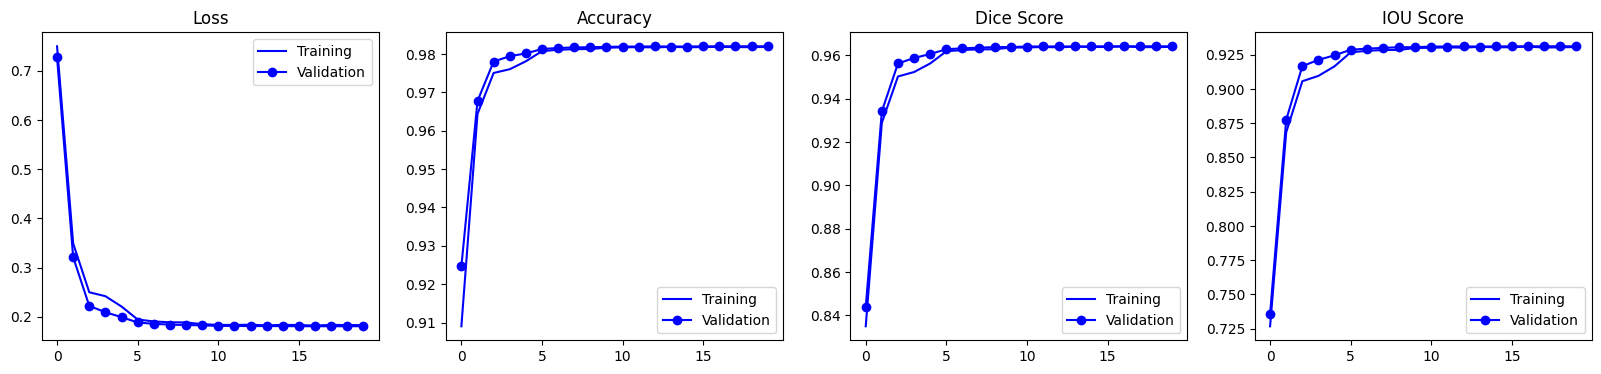

In [ ]:
plot_metrics (loss, val_loss, acc, val_acc, dice, val_dice, iou, val_iou)

In [ ]:
def tensor_to_array (img):
    return img.cpu ().numpy ().transpose (1, 2, 0)

In [ ]:
def show_results (model, valid_dl, checkpoint_path = None):
    """ showing image, mask and predicted mask for one batch """
    if checkpoint_path is not None:
        load_checkpoint (torch.load (checkpoint_path), model)

    images, masks = next (iter (valid_dl))
    images = images.to(device)
    masks = masks.unsqueeze (1).to(device)
    outputs = model (images)
    preds = (outputs > 0.5).float ()

    plt.figure (figsize = (15, 20))
    for i in range (len (preds)):
        plt.subplot (4, 3, 3 * i + 1)
        plt.title ('Orginal Image')
        image = images [i]
        plt.imshow (tensor_to_array (image), cmap = 'gray')

        plt.subplot (4, 3, 3 * i + 2)
        plt.title ('True Mask')
        mask = masks [i]
        plt.imshow (tensor_to_array (mask), cmap = 'gray')

        plt.subplot (4, 3, 3 * i + 3)
        plt.title ('Predicted Mask')
        pred = preds [i]
        plt.imshow (tensor_to_array (pred), cmap = 'gray')

    plt.show ()

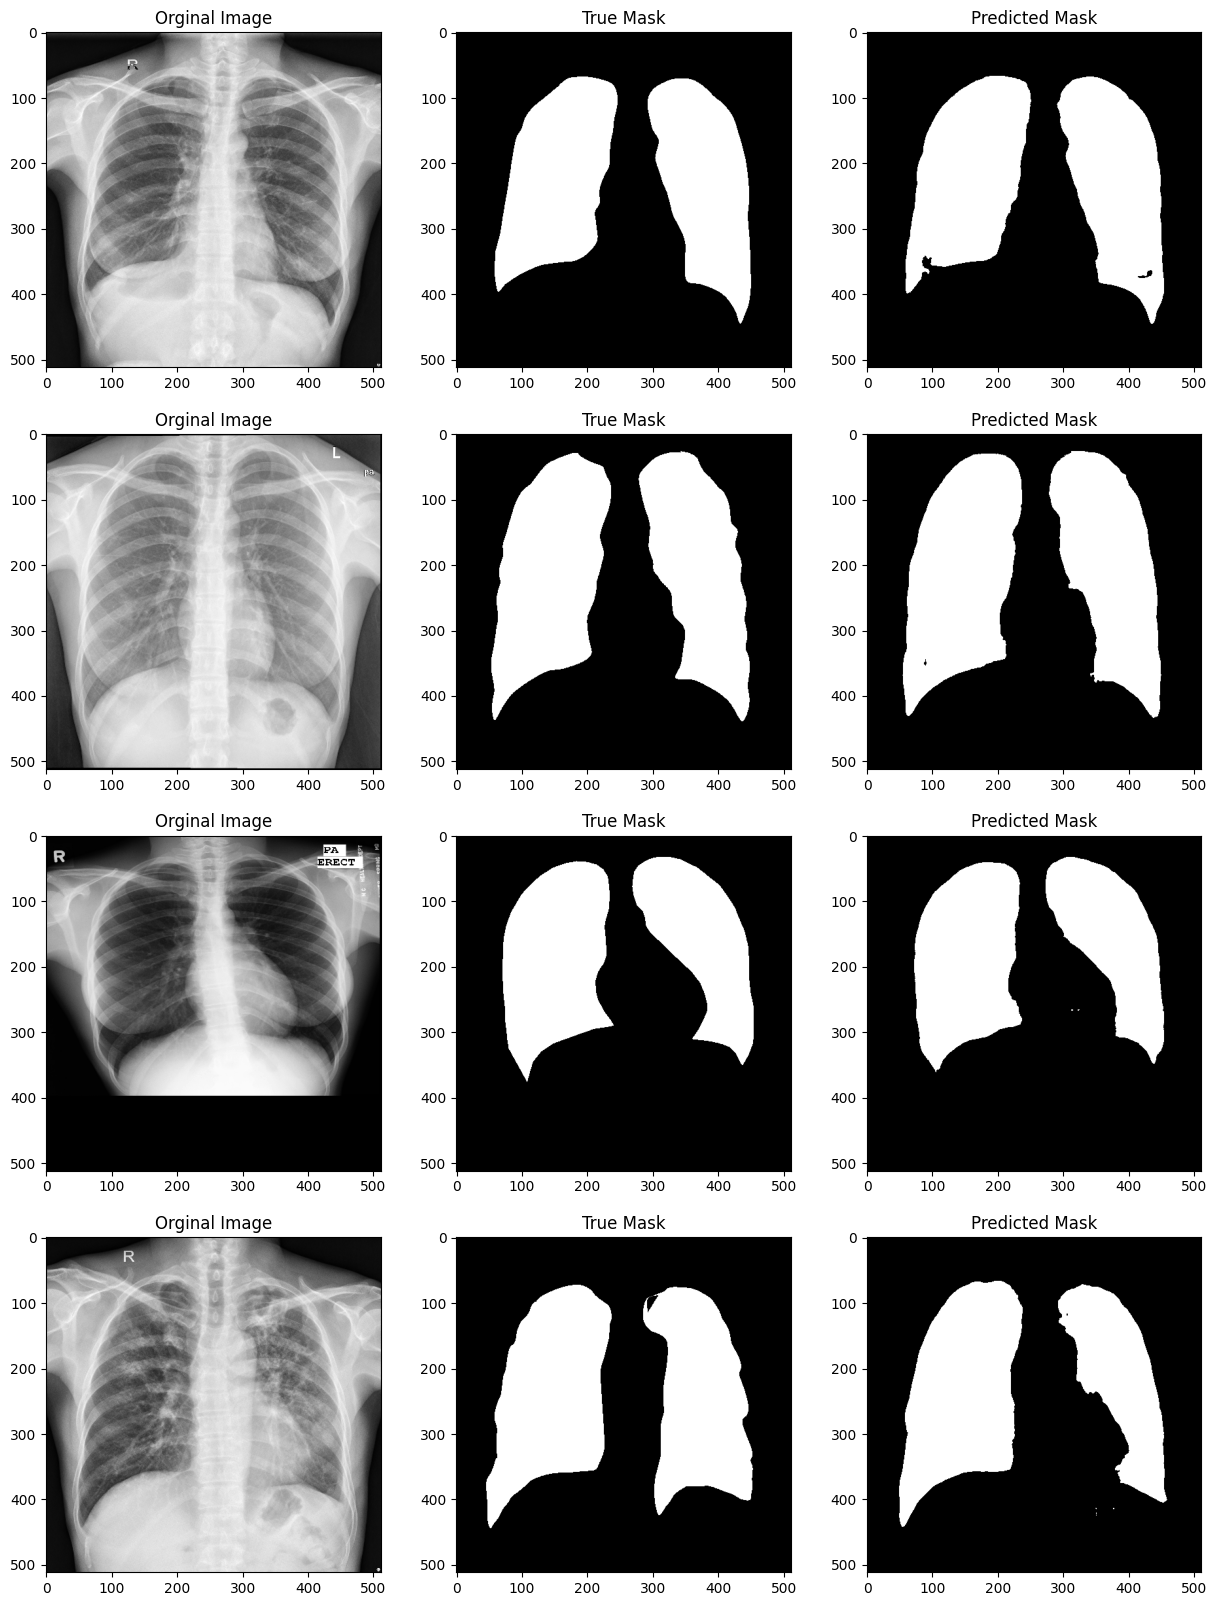

In [ ]:
show_results (model, valid_dl)